In [ ]:
# prompt: 구글 마운트

from google.colab import drive

# ✅ Google Drive 마운트
drive.mount('/content/drive')


Mounted at /content/drive


#AttentionWithMLP train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         196,864
            Linear-2                  [-1, 256]         262,400
            Linear-3                  [-1, 256]         262,400
            Linear-4                  [-1, 512]         131,584
              ReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                    [-1, 7]           3,591
Total params: 856,839
Trainable params: 856,839
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 3.27
Estimated Total Size (MB): 3.29
----------------------------------------------------------------
Epoch 01 | Train Acc: 0.6951 | Val Acc: 0.8208
Epoch 02 | Train Acc: 0.8376 | Val Acc: 0.8595
Epoch 03 | T

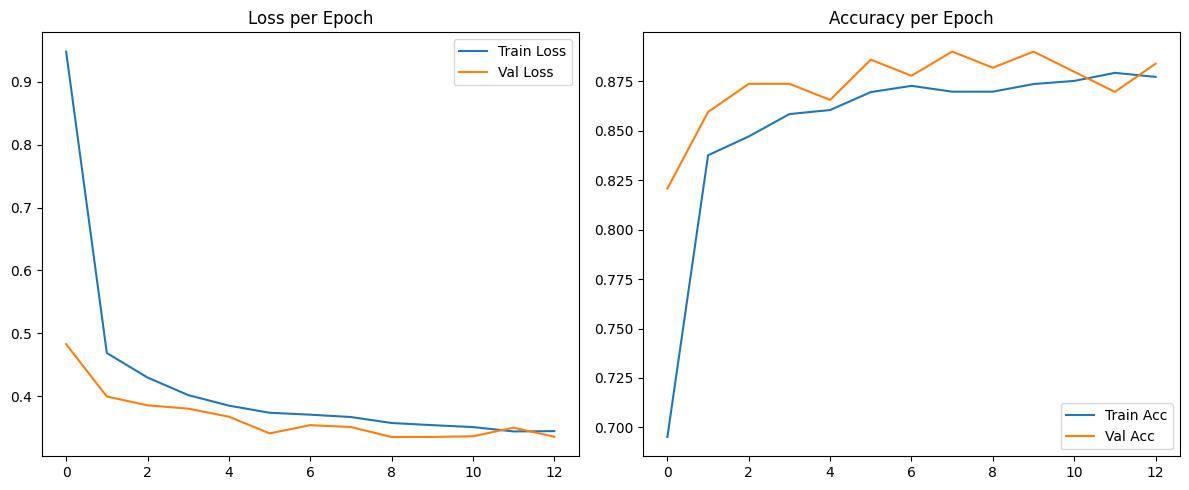

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
from torchsummary import summary


# ✅ Seed 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ✅ 모델 정의
class AttentionWithMLP(nn.Module):
    def __init__(self, cnn_dim=1024, clip_dim=768, attn_dim=256, mlp_hidden=512, num_classes=7):
        super().__init__()
        self.query_proj = nn.Linear(clip_dim, attn_dim)
        self.key_proj = nn.Linear(cnn_dim, attn_dim)
        self.value_proj = nn.Linear(cnn_dim, attn_dim)
        self.mlp = nn.Sequential(
            nn.Linear(attn_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(mlp_hidden, num_classes)
        )

    def forward(self, x):
        cnn_feat = x[:, :1024]
        clip_feat = x[:, 1024:]
        Q = self.query_proj(clip_feat)
        K = self.key_proj(cnn_feat)
        V = self.value_proj(cnn_feat)
        attn_score = torch.softmax((Q * K).sum(dim=1, keepdim=True), dim=1)
        context = attn_score * V
        out = self.mlp(context)
        return out

# ✅ 데이터 로드
X = np.load("/content/drive/MyDrive/raf-db/merged_features/merged_featuresX_cnn_clip_l2norm_v2.npy")
y = np.load("/content/drive/MyDrive/raf-db/merged_features/y_train.npy")
y -= 1  # 0부터 시작

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ✅ 모델 선택
model = AttentionWithMLP().cuda()
summary(model, input_size=(1792,))

# ✅ Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ✅ EarlyStopping
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=5)

# ✅ 학습 루프
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == batch_y).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == batch_y).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    early_stopper(val_acc)
    if early_stopper.early_stop:
        print("✅ Early stopping triggered!")
        break

# ✅ 그래프 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss per Epoch")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.legend()
plt.title("Accuracy per Epoch")

plt.tight_layout()
plt.show()


#모델 저장

In [ ]:
# ✅ 모델 저장 (예: AttentionWithMLP 모델 저장 시)
torch.save(model.state_dict(), "/content/drive/MyDrive/raf-db/merged_features/attention_with_mlp_model.pt")


#AttentionWithMLP Test

In [ ]:
import torch.nn as nn
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


# ✅ Attention + MLP 정의 (Case 3)
class AttentionWithMLP(nn.Module):
    def __init__(self, cnn_dim=1024, clip_dim=768, attn_dim=256, mlp_hidden=512, num_classes=7):
        super().__init__()
        self.query_proj = nn.Linear(clip_dim, attn_dim)
        self.key_proj = nn.Linear(cnn_dim, attn_dim)
        self.value_proj = nn.Linear(cnn_dim, attn_dim)
        self.mlp = nn.Sequential(
            nn.Linear(attn_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(mlp_hidden, num_classes)
        )

    def forward(self, x):
        cnn_feat = x[:, :1024]
        clip_feat = x[:, 1024:]
        Q = self.query_proj(clip_feat)
        K = self.key_proj(cnn_feat)
        V = self.value_proj(cnn_feat)
        attn_score = torch.softmax((Q * K).sum(dim=1, keepdim=True), dim=1)
        context = attn_score * V
        out = self.mlp(context)
        return out

# ✅ 모델 선택
model = AttentionWithMLP().cuda()

# ✅ 모델 로드 (파일 경로 주의!)
model.load_state_dict(torch.load("/content/drive/MyDrive/raf-db/merged_features/attention_with_mlp_model.pt"))
model.eval()

# ✅ 테스트셋 로드
X_test = np.load("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.npy")
y_test = np.load("/content/drive/MyDrive/raf-db/merged_features/y_test.npy")
y_test -= 1  # 라벨 0부터 시작

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 평가
all_preds, all_labels = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.cuda()
        outputs = model(batch_X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# ✅ 정확도, F1-score, 상세 분류 리포트
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Test Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

# ✅ 클래스별 Precision, Recall, F1-score
print(classification_report(all_labels, all_preds, digits=4))

✅ Test Accuracy: 0.8226 | F1-score: 0.8224
              precision    recall  f1-score   support

           0     0.7791    0.8171    0.7976       164
           1     0.6786    0.5135    0.5846        37
           2     0.5422    0.5625    0.5521        80
           3     0.9247    0.9122    0.9184       592
           4     0.8372    0.7531    0.7930       239
           5     0.7284    0.7284    0.7284        81
           6     0.7676    0.8353    0.8000       340

    accuracy                         0.8226      1533
   macro avg     0.7511    0.7317    0.7392      1533
weighted avg     0.8243    0.8226    0.8224      1533



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         459,008
            Linear-2               [-1, 1, 256]         459,008
            Linear-3               [-1, 1, 256]         459,008
            Linear-4                  [-1, 256]          65,792
            Linear-5                  [-1, 512]         131,584
              ReLU-6                  [-1, 512]               0
           Dropout-7                  [-1, 512]               0
            Linear-8                    [-1, 7]           3,591
Total params: 1,577,991
Trainable params: 1,577,991
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 6.02
Estimated Total Size (MB): 6.05
----------------------------------------------------------------
Epoch 01 | Train Acc: 0.6775 | Val Acc

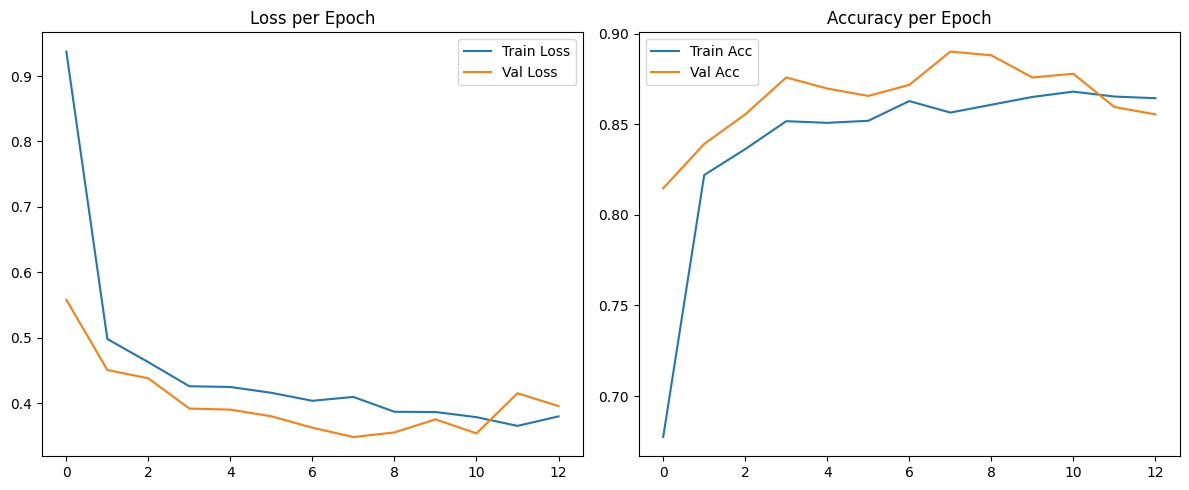

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import random

# ✅ Seed 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ✅ 모델 정의
class SelfAttentionMLP(nn.Module):
    def __init__(self, input_dim=1792, attn_dim=256, mlp_hidden=512, num_classes=7):
        super().__init__()
        self.q_proj = nn.Linear(input_dim, attn_dim)
        self.k_proj = nn.Linear(input_dim, attn_dim)
        self.v_proj = nn.Linear(input_dim, attn_dim)

        self.attn_fc = nn.Linear(attn_dim, attn_dim)  # context output 차원 유지
        self.mlp = nn.Sequential(
            nn.Linear(attn_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(mlp_hidden, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)

        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)

        attn_weights = torch.softmax(torch.matmul(Q, K.transpose(-2, -1)) / (Q.shape[-1] ** 0.5), dim=-1)
        context = torch.matmul(attn_weights, V).squeeze(1)
        out = self.mlp(self.attn_fc(context))
        return out

# ✅ 데이터 로드
X = np.load("/content/drive/MyDrive/raf-db/merged_features/merged_featuresX_cnn_clip_l2norm_v2.npy")
y = np.load("/content/drive/MyDrive/raf-db/merged_features/y_train.npy")
y -= 1  # 0부터 시작

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ✅ 모델 선택
model = SelfAttentionMLP().cuda()  # ← 이걸로 바꾸면 Attention-only 실험 가능

summary(model, input_size=(1792,))

# ✅ Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ✅ EarlyStopping
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=5)

# ✅ 학습 루프
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == batch_y).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == batch_y).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    early_stopper(val_acc)
    if early_stopper.early_stop:
        print("✅ Early stopping triggered!")
        break

# ✅ 그래프 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss per Epoch")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.legend()
plt.title("Accuracy per Epoch")

plt.tight_layout()
plt.show()


In [ ]:
# ✅ 모델 저장 (예: AttentionWithMLP 모델 저장 시)
torch.save(model.state_dict(), "/content/drive/MyDrive/raf-db/merged_features/selfattention_with_mlp_model.pt")

In [ ]:
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# ✅ Attention + MLP 정의 (Case 3)
class SelfAttentionMLP(nn.Module):
    def __init__(self, input_dim=1792, attn_dim=256, mlp_hidden=512, num_classes=7):
        super().__init__()
        self.q_proj = nn.Linear(input_dim, attn_dim)
        self.k_proj = nn.Linear(input_dim, attn_dim)
        self.v_proj = nn.Linear(input_dim, attn_dim)

        self.attn_fc = nn.Linear(attn_dim, attn_dim)  # context output 차원 유지
        self.mlp = nn.Sequential(
            nn.Linear(attn_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(mlp_hidden, num_classes)
        )

    def forward(self, x):
        # x: [B, 1792] → [B, 1, 1792]
        x = x.unsqueeze(1)

        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)

        attn_weights = torch.softmax(torch.matmul(Q, K.transpose(-2, -1)) / (Q.shape[-1] ** 0.5), dim=-1)  # [B, 1, 1]
        context = torch.matmul(attn_weights, V).squeeze(1)  # [B, attn_dim]
        out = self.mlp(self.attn_fc(context))  # context → MLP → logit
        return out

# ✅ 모델 선택
model = SelfAttentionMLP().cuda()

# ✅ 모델 로드 (파일 경로 주의!)
model.load_state_dict(torch.load("/content/drive/MyDrive/raf-db/merged_features/selfattention_with_mlp_model.pt"))
model.eval()

# ✅ 테스트셋 로드
X_test = np.load("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.npy")
y_test = np.load("/content/drive/MyDrive/raf-db/merged_features/y_test.npy")
y_test -= 1  # 라벨 0부터 시작

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 평가
all_preds, all_labels = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.cuda()
        outputs = model(batch_X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# ✅ 정확도, F1-score, 상세 분류 리포트
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Test Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

# ✅ 클래스별 Precision, Recall, F1-score
print(classification_report(all_labels, all_preds, digits=4))

✅ Test Accuracy: 0.8147 | F1-score: 0.8116
              precision    recall  f1-score   support

           0     0.7554    0.8476    0.7989       164
           1     0.7778    0.3784    0.5091        37
           2     0.5190    0.5125    0.5157        80
           3     0.9112    0.9189    0.9151       592
           4     0.8190    0.7573    0.7870       239
           5     0.8654    0.5556    0.6767        81
           6     0.7461    0.8382    0.7895       340

    accuracy                         0.8147      1533
   macro avg     0.7706    0.6869    0.7131      1533
weighted avg     0.8174    0.8147    0.8116      1533



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         196,864
            Linear-2                  [-1, 256]         262,400
            Linear-3                  [-1, 256]         262,400
            Linear-4                  [-1, 256]          65,792
            Linear-5                  [-1, 512]         131,584
              ReLU-6                  [-1, 512]               0
           Dropout-7                  [-1, 512]               0
            Linear-8                    [-1, 7]           3,591
Total params: 922,631
Trainable params: 922,631
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 3.52
Estimated Total Size (MB): 3.55
----------------------------------------------------------------
Epoch 01 | Train Acc: 0.6929 | Val Acc: 0.

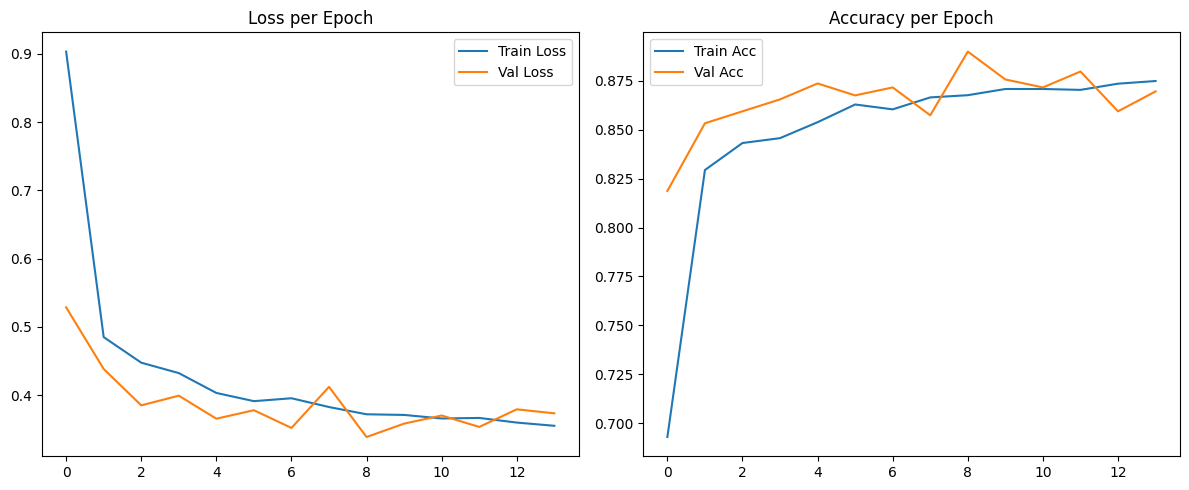

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
from torchsummary import summary

# ✅ Seed 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ✅ 모델 정의
class CrossAttentionMLP(nn.Module):
    def __init__(self, cnn_dim=1024, clip_dim=768, attn_dim=256, mlp_hidden=512, num_classes=7):
        super().__init__()
        self.attn_dim = attn_dim  # ⭐ 이 부분 추가!

        self.query_proj = nn.Linear(clip_dim, attn_dim)
        self.key_proj = nn.Linear(cnn_dim, attn_dim)
        self.value_proj = nn.Linear(cnn_dim, attn_dim)

        self.attn_fc = nn.Linear(attn_dim, attn_dim)  # optional
        self.mlp = nn.Sequential(
            nn.Linear(attn_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(mlp_hidden, num_classes)
        )

    def forward(self, x):
        cnn_feat = x[:, :1024]
        clip_feat = x[:, 1024:]

        Q = self.query_proj(clip_feat).unsqueeze(1)
        K = self.key_proj(cnn_feat).unsqueeze(1)
        V = self.value_proj(cnn_feat).unsqueeze(1)

        attn_weights = torch.softmax(torch.matmul(Q, K.transpose(-2, -1)) / (self.attn_dim ** 0.5), dim=-1)
        context = torch.matmul(attn_weights, V).squeeze(1)

        out = self.mlp(self.attn_fc(context))
        return out



# ✅ 데이터 로드
X = np.load("/content/drive/MyDrive/raf-db/merged_features/merged_featuresX_cnn_clip_l2norm_v2.npy")
y = np.load("/content/drive/MyDrive/raf-db/merged_features/y_train.npy")
y -= 1  # 0부터 시작

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ✅ 모델 선택
model = CrossAttentionMLP().cuda()  # ← 이걸로 바꾸면 Attention-only 실험 가능

summary(model, input_size=(1792,))

# ✅ Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ✅ EarlyStopping
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
        self.early_stop = False

    def __call__(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            print(f"🛑 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=5)

# ✅ 학습 루프
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(50):
    model.train()
    train_loss, train_correct = 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == batch_y).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == batch_y).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    early_stopper(val_acc)
    if early_stopper.early_stop:
        print("✅ Early stopping triggered!")
        break

# ✅ 그래프 출력
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss per Epoch")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.legend()
plt.title("Accuracy per Epoch")

plt.tight_layout()
plt.show()


In [ ]:
# ✅ 모델 저장 (예: AttentionWithMLP 모델 저장 시)
torch.save(model.state_dict(), "/content/drive/MyDrive/raf-db/merged_features/Crossattention_with_mlp_model.pt")

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt


# ✅ Attention + MLP 정의 (Case 3)
class CrossAttentionMLP(nn.Module):
    def __init__(self, cnn_dim=1024, clip_dim=768, attn_dim=256, mlp_hidden=512, num_classes=7):
        super().__init__()
        self.attn_dim = attn_dim  # ⭐ 이 부분 추가!

        self.query_proj = nn.Linear(clip_dim, attn_dim)
        self.key_proj = nn.Linear(cnn_dim, attn_dim)
        self.value_proj = nn.Linear(cnn_dim, attn_dim)

        self.attn_fc = nn.Linear(attn_dim, attn_dim)  # optional
        self.mlp = nn.Sequential(
            nn.Linear(attn_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(mlp_hidden, num_classes)
        )

    def forward(self, x):
        cnn_feat = x[:, :1024]  # [B, cnn_dim]
        clip_feat = x[:, 1024:]  # [B, clip_dim]

        Q = self.query_proj(clip_feat).unsqueeze(1)  # [B, 1, attn_dim]
        K = self.key_proj(cnn_feat).unsqueeze(1)     # [B, 1, attn_dim]
        V = self.value_proj(cnn_feat).unsqueeze(1)   # [B, 1, attn_dim]

        # 🔧 수정: self.attn_dim 사용
        attn_weights = torch.softmax(torch.matmul(Q, K.transpose(-2, -1)) / (self.attn_dim ** 0.5), dim=-1)
        context = torch.matmul(attn_weights, V).squeeze(1)  # [B, attn_dim]

        out = self.mlp(self.attn_fc(context))
        return out


# ✅ 모델 선택
model = CrossAttentionMLP().cuda()

# ✅ 모델 로드 (파일 경로 주의!)
model.load_state_dict(torch.load("/content/drive/MyDrive/raf-db/merged_features/Crossattention_with_mlp_model.pt"))
model.eval()

# ✅ 테스트셋 로드
X_test = np.load("/content/drive/MyDrive/raf-db/merged_features/X_test_cnn_clip_l2norm_v2.npy")
y_test = np.load("/content/drive/MyDrive/raf-db/merged_features/y_test.npy")
y_test -= 1  # 라벨 0부터 시작

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 평가
all_preds, all_labels = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.cuda()
        outputs = model(batch_X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# ✅ 정확도, F1-score, 상세 분류 리포트
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"✅ Test Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

# ✅ 클래스별 Precision, Recall, F1-score
print(classification_report(all_labels, all_preds, digits=4))


✅ Test Accuracy: 0.8089 | F1-score: 0.8075
              precision    recall  f1-score   support

           0     0.7407    0.8537    0.7932       164
           1     0.6667    0.3784    0.4828        37
           2     0.5507    0.4750    0.5101        80
           3     0.9353    0.8784    0.9059       592
           4     0.7888    0.7657    0.7771       239
           5     0.8235    0.6914    0.7517        81
           6     0.7261    0.8500    0.7832       340

    accuracy                         0.8089      1533
   macro avg     0.7474    0.6989    0.7148      1533
weighted avg     0.8128    0.8089    0.8075      1533



#cnn 베이스라인

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report
import os
import random

# ✅ 시드 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ✅ 시드 고정 실행
set_seed(42)

# ✅ 환경 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 7

# ✅ transform 조합들
transform_list = {
    "flip": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ]),
}

# ✅ transform (테스트용)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ✅ 테스트셋 로드
test_dir = "/content/drive/MyDrive/Colab Notebooks/emotion_ai/RAF-DB-HALF/test_half"
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ DenseNet121 모델 정의 및 불러오기
model = models.densenet121(pretrained=False)
model.classifier = nn.Linear(1024, NUM_CLASSES)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/emotion_ai/densenet121_flip.pth", map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

# ✅ 예측
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# ✅ 분류 리포트 출력
print(classification_report(all_labels, all_preds, digits=4))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


              precision    recall  f1-score   support

           0     0.6884    0.8354    0.7548       164
           1     0.4324    0.4324    0.4324        37
           2     0.4889    0.5500    0.5176        80
           3     0.8858    0.9172    0.9012       592
           4     0.6515    0.8368    0.7326       239
           5     0.8113    0.5309    0.6418        81
           6     0.8419    0.5794    0.6864       340

    accuracy                         0.7697      1533
   macro avg     0.6857    0.6689    0.6667      1533
weighted avg     0.7828    0.7697    0.7666      1533

